In [1]:
import psycopg2
import pandas as pd 
# from sqlalchemy.types import Integer, Text, String, DateTime
import sqlalchemy as s
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

with open("config.json") as config_file:
    config = json.load(config_file)

database_connection_string = 'postgres+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = s.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [2]:
repo_list = pd.DataFrame()
repo_list_query = f"""
SELECT repo_id, repo_name, repo_path from repo
WHERE repo_name = 'concourse' OR repo_name = 'postfacto' or repo_name = 'clarity' or repo_name = 'gpdb' or
      repo_name = 'kpack' or repo_name = 'rabbitmq-server' or repo_name = 'sonobuoy' or repo_name = 'contour' or
      repo_name = 'oraclelinux-extras-base' or repo_name = 'tern';
    """
repo_list = pd.read_sql_query(repo_list_query, con=engine)
print(repo_list)

    repo_id                repo_name                              repo_path
0     27913                  clarity                     github.com/vmware/
1     25857                     gpdb               github.com/greenplum-db/
2     30000                  contour             github.com/projectcontour/
3     26983                postfacto                    github.com/pivotal/
4     26235                concourse               github.com/pcfdev-forks/
5     25432          rabbitmq-server                   github.com/rabbitmq/
6     28030                 sonobuoy               github.com/vmware-tanzu/
7     26600                     gpdb  github.com/Pivotal-Field-Engineering/
8     27169                     gpdb                github.com/pivotal-gss/
9     28051                concourse                  github.com/concourse/
10    27043                    kpack                    github.com/pivotal/
11    27940                     tern                 github.com/tern-tools/
12    30160 

In [3]:
## List of repository IDs for the report
#repo_dict = {25760, 25663} #spring-boot & spring-framework
#repo_dict = {28051} # concourse
repo_dict = {26983} #postfacto
#repo_dict = {25432} #rabbitmq-server
#repo_dict = {25663} #spring-framework
#repo_dict = {25760} #sprint-boot
#repo_dict = {28030} #sonobuoy
#repo_dict = {28031} #velero
#repo_dict = {27913} #clarity
#repo_dict = {30000} #contour
#repo_dict = {27940} #tern

In [4]:
#from datetime import date
import datetime 

current = datetime.date.today()
today = "'" + str(current) + "'"
print(today)

first_current = current.replace(day=1)
last_month = first_current - datetime.timedelta(days=1)
end_date = "'" + str(last_month) + "'"
print(end_date)

print

start = last_month - datetime.timedelta(days=365)
year_ago = "'" + str(start) + "'"
print(year_ago)

'2020-04-30'
'2020-03-31'
'2019-04-01'


In [5]:
pr_all = pd.DataFrame()

for repo_id in repo_dict: 

    pr_query = s.sql.text(f"""
                     SELECT
                        repo.repo_id AS repo_id,
                        pull_requests.pr_src_id AS pr_src_id,
                        repo.repo_name AS repo_name,
                        pr_src_author_association,
                        repo_groups.rg_name AS repo_group,
                        pull_requests.pr_src_state,
                        pull_requests.pr_merged_at,
                        pull_requests.pr_created_at AS pr_created_at,
                        pull_requests.pr_closed_at AS pr_closed_at,
                        date_part( 'year', pr_created_at :: DATE ) AS CREATED_YEAR,
                        date_part( 'month', pr_created_at :: DATE ) AS CREATED_MONTH,
                        date_part( 'year', pr_closed_at :: DATE ) AS CLOSED_YEAR,
                        date_part( 'month', pr_closed_at :: DATE ) AS CLOSED_MONTH,
                        pr_src_meta_label,
                        pr_head_or_base,
                        ( EXTRACT ( EPOCH FROM pull_requests.pr_closed_at ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 3600 AS hours_to_close,
                        ( EXTRACT ( EPOCH FROM pull_requests.pr_closed_at ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 86400 AS days_to_close, 
                        ( EXTRACT ( EPOCH FROM first_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 3600 AS hours_to_first_response,
                        ( EXTRACT ( EPOCH FROM first_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 86400 AS days_to_first_response, 
                        ( EXTRACT ( EPOCH FROM last_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 3600 AS hours_to_last_response,
                        ( EXTRACT ( EPOCH FROM last_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 86400 AS days_to_last_response, 
                        first_response_time,
                        last_response_time,
                        average_time_between_responses,
                        assigned_count,
                        review_requested_count,
                        labeled_count,
                        subscribed_count,
                        mentioned_count,
                        referenced_count,
                        closed_count,
                        head_ref_force_pushed_count,
                        merged_count,
                        milestoned_count,
                        unlabeled_count,
                        head_ref_deleted_count,
                        comment_count,
                        lines_added, 
                        lines_removed,
                        commit_count, 
                        file_count
                    FROM
                    repo,
                    repo_groups,
                    pull_requests LEFT OUTER JOIN ( 
                            SELECT pull_requests.pull_request_id,
                                MIN(message.msg_timestamp) AS first_response_time,
                                COUNT(DISTINCT message.msg_timestamp) AS comment_count,
                                MAX(message.msg_timestamp) AS last_response_time,
                                (MAX(message.msg_timestamp) - MIN(message.msg_timestamp)) / COUNT(DISTINCT message.msg_timestamp) AS average_time_between_responses
                            FROM repo, 
                                pull_requests left outer join pull_request_message_ref 
                                on pull_requests.pull_request_id = pull_request_message_ref.pull_request_id
                                left outer join message on pull_request_message_ref.msg_id = message.msg_id and cntrb_id not in (select cntrb_id from contributors where cntrb_login like '%[bot]')
                            WHERE repo.repo_id = {repo_id}
                            AND repo.repo_id = pull_requests.repo_id
                            GROUP BY pull_requests.pull_request_id
                    ) response_times
                    ON pull_requests.pull_request_id = response_times.pull_request_id
                    left outer join (
                            SELECT pull_requests.pull_request_id,
                                count(*) FILTER (WHERE action = 'assigned') AS assigned_count,
                                count(*) FILTER (WHERE action = 'review_requested') AS review_requested_count,
                                count(*) FILTER (WHERE action = 'labeled') AS labeled_count,
                                count(*) FILTER (WHERE action = 'unlabeled') AS unlabeled_count,
                                count(*) FILTER (WHERE action = 'subscribed') AS subscribed_count,
                                count(*) FILTER (WHERE action = 'mentioned') AS mentioned_count,
                                count(*) FILTER (WHERE action = 'referenced') AS referenced_count,
                                count(*) FILTER (WHERE action = 'closed') AS closed_count,
                                count(*) FILTER (WHERE action = 'head_ref_force_pushed') AS head_ref_force_pushed_count,
                                count(*) FILTER (WHERE action = 'head_ref_deleted') AS head_ref_deleted_count,
                                count(*) FILTER (WHERE action = 'milestoned') AS milestoned_count,
                                count(*) FILTER (WHERE action = 'merged') AS merged_count
                            from repo, pull_requests left outer join pull_request_events 
                                on pull_requests.pull_request_id = pull_request_events.pull_request_id
                            WHERE repo.repo_id = {repo_id}
                                AND repo.repo_id = pull_requests.repo_id
                            GROUP BY pull_requests.pull_request_id
                    ) event_counts on event_counts.pull_request_id = pull_requests.pull_request_id
                    LEFT OUTER JOIN (
                            SELECT pull_request_commits.pull_request_id, count(DISTINCT pr_cmt_sha) AS commit_count                                FROM pull_request_commits, pull_requests, pull_request_meta
                            WHERE pull_requests.pull_request_id = pull_request_commits.pull_request_id
                            AND pull_requests.pull_request_id = pull_request_meta.pull_request_id
                            AND pull_requests.repo_id = {repo_id}
                            AND pr_cmt_sha <> pull_requests.pr_merge_commit_sha
                            AND pr_cmt_sha <> pull_request_meta.pr_sha
                            GROUP BY pull_request_commits.pull_request_id
                    ) all_commit_counts
                    ON pull_requests.pull_request_id = all_commit_counts.pull_request_id
                    LEFT OUTER JOIN (
                            SELECT MAX(pr_repo_meta_id), pull_request_meta.pull_request_id, pr_head_or_base, pr_src_meta_label
                            FROM pull_requests, pull_request_meta
                            WHERE pull_requests.pull_request_id = pull_request_meta.pull_request_id
                            AND pull_requests.repo_id = {repo_id}
                            AND pr_head_or_base = 'base'
                            GROUP BY pull_request_meta.pull_request_id, pr_head_or_base, pr_src_meta_label
                    ) base_labels
                    ON base_labels.pull_request_id = pull_requests.pull_request_id
                    LEFT OUTER JOIN (
                            SELECT sum(cmt_added) AS lines_added, sum(cmt_removed) AS lines_removed, pull_request_commits.pull_request_id, count(DISTINCT cmt_filename) AS file_count
                            FROM pull_request_commits, commits, pull_requests, pull_request_meta
                            WHERE cmt_commit_hash = pr_cmt_sha
                            AND pull_requests.pull_request_id = pull_request_commits.pull_request_id
                            AND pull_requests.pull_request_id = pull_request_meta.pull_request_id
                            AND pull_requests.repo_id = {repo_id}
                            AND commits.repo_id = pull_requests.repo_id
                            AND commits.cmt_commit_hash <> pull_requests.pr_merge_commit_sha
                            AND commits.cmt_commit_hash <> pull_request_meta.pr_sha
                            GROUP BY pull_request_commits.pull_request_id
                    ) master_merged_counts 
                    ON pull_requests.pull_request_id = master_merged_counts.pull_request_id                   
                    WHERE 
                        repo.repo_group_id = repo_groups.repo_group_id 
                        AND repo.repo_id = pull_requests.repo_id 
                        AND repo.repo_id = {repo_id}
                        AND pr_created_at >= {year_ago}
                        AND pr_created_at <= {end_date}
                    ORDER BY
                       merged_count DESC
                       """)
    pr_a = pd.read_sql(pr_query, con=engine)
    if not pr_all.empty: 
        pr_all = pd.concat([pr_all, pr_a]) 
    else: 
        # first repo
        pr_all = pr_a
        
    get_repo_name_query = f"""
        SELECT repo_name from repo where repo_id = {repo_id};
           """
    get_repo_name = pd.read_sql_query(get_repo_name_query, con=engine)
    repo_name = get_repo_name.repo_name[0]

In [7]:
pr_all

60

In [66]:
pr_all['first_response_time']

0                    NaT
1    2019-08-14 05:45:08
2    2019-08-14 07:57:42
3    2019-09-29 07:57:42
4    2019-08-16 17:10:49
5    2019-09-10 05:50:20
6    2019-10-21 15:03:10
7    2019-10-27 10:16:28
8    2019-10-27 21:08:55
9    2019-12-12 16:06:03
10   2019-07-16 14:05:05
11   2019-05-05 15:03:28
12   2019-06-05 15:51:08
13                   NaT
14                   NaT
15   2019-07-16 10:46:16
16   2019-07-19 19:23:56
17                   NaT
18                   NaT
19                   NaT
20                   NaT
21   2019-11-21 10:43:31
22                   NaT
23   2019-06-27 12:20:01
24                   NaT
25                   NaT
26                   NaT
27                   NaT
28   2019-07-19 12:32:08
29   2019-07-20 15:56:09
30                   NaT
31   2019-07-29 18:46:23
32                   NaT
33                   NaT
34   2019-09-04 07:47:20
35                   NaT
36                   NaT
37   2019-08-12 14:02:57
38                   NaT
39   2019-12-07 06:22:30


In [67]:
    from pandas.tseries.offsets import BusinessDay

    bd = pd.tseries.offsets.BusinessDay(n = 2) 

    pr_all['diff'] = pr_all.first_response_time - pr_all.pr_created_at
    pr_all['2_bus_days'] = pr_all.pr_created_at + bd
    pr_all['yearmonth'] = pr_all['pr_created_at'].dt.strftime('%Y-%m')

    pr_all['in_guidelines'] = np.where(pr_all['2_bus_days'] < pr_all['first_response_time'], 0, 1)

    year_month_list = pr_all.yearmonth.unique()
    year_month_list.sort()
    first_response = pr_all.groupby(['repo_name', 'yearmonth'], as_index=False).sum()[['repo_name', 'yearmonth', 'in_guidelines']]

    # counts total number of PRs each month
    total_by_month = pr_all.groupby(['repo_name', 'yearmonth'], as_index=False).count()[['repo_name', 'yearmonth', 'pr_created_at']]

    first_response['total_prs'] = total_by_month['pr_created_at']
    first_response['out_guidelines'] = first_response['total_prs'] - first_response['in_guidelines']
    first_response['in_percent'] = first_response['in_guidelines'] / first_response['total_prs']
    first_response['out_percent'] = first_response['out_guidelines'] / first_response['total_prs']
    print(first_response)

    #for x in pr_all.iterrows():
    #    if x[1]['first_response_time'] > x[1]['2_bus_days']:
    #        print(x[1]['pr_created_at'], x[1]['first_response_time'], x[1]['pr_closed_at'], x[1]['diff'], x[1]['2_bus_days'])

    repo_name yearmonth  in_guidelines  total_prs  out_guidelines  in_percent  \
0   postfacto   2019-05              2          3               1    0.666667   
1   postfacto   2019-06              1          2               1    0.500000   
2   postfacto   2019-07             17         18               1    0.944444   
3   postfacto   2019-08             10         11               1    0.909091   
4   postfacto   2019-09              3          3               0    1.000000   
5   postfacto   2019-10              8          8               0    1.000000   
6   postfacto   2019-11              4          5               1    0.800000   
7   postfacto   2019-12              3          3               0    1.000000   
8   postfacto   2020-01              1          1               0    1.000000   
9   postfacto   2020-02              3          3               0    1.000000   
10  postfacto   2020-03              3          3               0    1.000000   

    out_percent  
0      0.

1


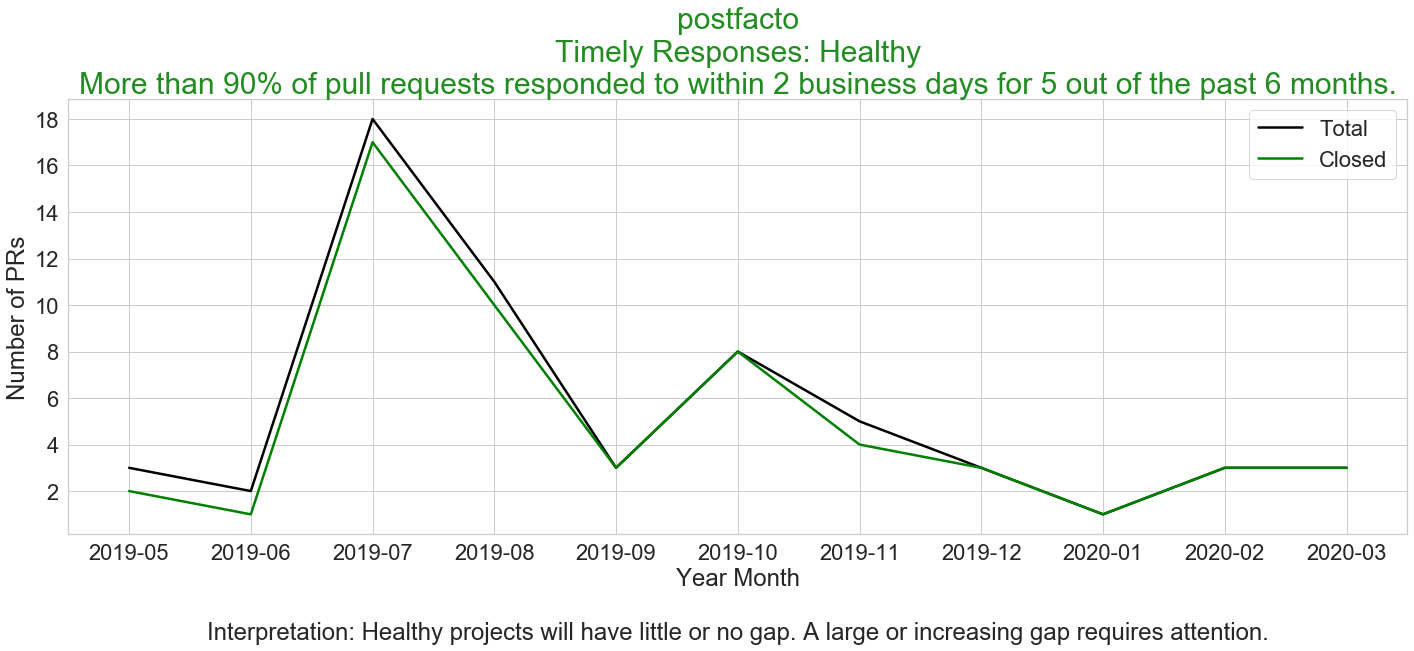

In [78]:
    #pr_sustainDF['repo_id'] = pr_sustainDF['repo_id'].map(int)
    #pr_sustainDF['yearmonth'] = pr_sustainDF['yearmonth'].map(str)
    #pr_sustainDF.set_index('repo_id', 'yearmonth')
    
    from matplotlib.ticker import MaxNLocator

    sns.set_style('ticks')
    sns.set(style="whitegrid", font_scale=2)

    fig, ax = plt.subplots()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    # the size of A4 paper
    fig.set_size_inches(24, 8)

    risk_num = 0
    m = 1
    for percent in first_response['out_percent']:
        if (percent > 0.10 and m > 6):
            risk_num+=1
        m+=1
    print(risk_num)

    title = repo_name + "\nTimely Responses:"

    if risk_num >= 2:
        title += " AT RISK\n" + str(risk_num) + " month(s) with > 10% of pull requests not responded to within 2 business days in the past 6 months."
        title_color = 'firebrick'
    else:
        title += " Healthy\nMore than 90% of pull requests responded to within 2 business days for " + str(6 - risk_num) + " out of the past 6 months."
        title_color = 'forestgreen'

    plottermonth = sns.lineplot(x='yearmonth', y='total_prs', data=first_response, sort=False, color='black', label='Total', linewidth=2.5)
    plottermonth = sns.lineplot(x='yearmonth', y='in_guidelines', data=first_response, sort=False, color='green', label='Closed', linewidth=2.5, linestyle='dashed').set_title(title, fontsize=30, color=title_color) 

    plottermonthlabels = ax.set_xticklabels(first_response['yearmonth'])
    plottermonthlabels = ax.set_ylabel('Number of PRs')
    plottermonthlabels = ax.set_xlabel('Year Month\n\nInterpretation: Healthy projects will have little or no gap. A large or increasing gap requires attention.')

    #today = datetime.date.today()
    #current_year_month = str(today.year) + '-' + '{:02d}'.format(today.month)

    #filename = 'output/sustains_pr_' + repo_name + "_" + current_year_month + '.png'

    #fig.savefig(filename, bbox_inches='tight')'''

In [10]:
    bar_colors = []
    k = 1
    risk_num = 0
    for med in first_response_median.diff_days:
        if med > 1:
            bar_colors.append('red')
            if k >= 6:
                risk_num+=1
        else:
            bar_colors.append('lightblue')
        k+=1
    print(risk_num, bar_colors)

0 ['lightblue', 'lightblue', 'lightblue', 'red', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue']


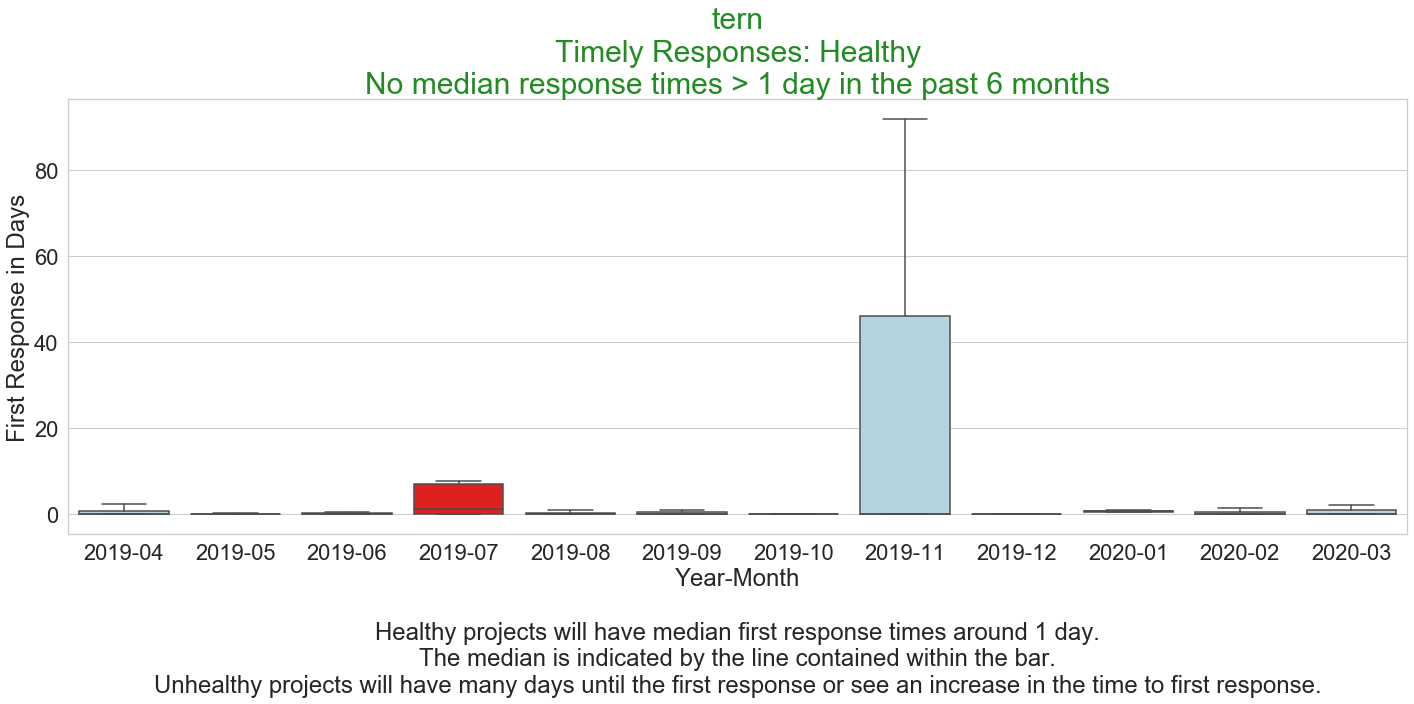

In [11]:
sns.set_style('ticks')
sns.set(style="whitegrid", font_scale=2)

fig, ax = plt.subplots()
fig.set_size_inches(24, 8)

title = repo_name + "\nTimely Responses:"

if risk_num >= 1:
    title += " AT RISK\n" + str(risk_num) + " month(s) with median response times > 1 day in the past 6 months"
    title_color = 'firebrick'
else:
    title += " Healthy\nNo median response times > 1 day in the past 6 months"
    title_color = 'forestgreen'

my_plot = sns.boxplot(x='yearmonth', y='diff_days', palette=bar_colors, data=pr_all, ax=ax, order=year_month_list, showfliers = False, whis=3).set_title(title, fontsize=30, color=title_color)

risk_bar_labels = ax.set_ylabel('First Response in Days')
risk_bar_labels = ax.set_xlabel('Year-Month\n\nHealthy projects will have median first response times around 1 day.\nThe median is indicated by the line contained within the bar.\nUnhealthy projects will have many days until the first response or see an increase in the time to first response.')